In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import pandas as pd
from xgboost import XGBClassifier
import xgboost
import warnings
import random
warnings.filterwarnings("ignore")

import json
import os
import os.path as op
from pathlib   import Path
from glob      import glob
from tqdm      import tqdm
from datetime  import datetime
import csv
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/adimnaku/CS155MiniProject1-Kaggle/main/train_basic_features.csv")
df = df.dropna()

df_test = pd.read_csv("https://raw.githubusercontent.com/adimnaku/CS155MiniProject1-Kaggle/main/test_basic_features.csv")
test_uids = df_test['uid']
df_test = df_test.drop(columns=['label', 'uid'])

df

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration
0,lab_0_0,0,0.173088,0.100141,51.926349,40.408772,300.0
1,lab_0_1,0,0.165048,0.086194,49.514298,32.957322,300.0
2,lab_0_2,0,0.167388,0.099177,50.216438,31.649486,300.0
3,lab_0_3,0,0.215927,0.109797,64.778077,42.524948,300.0
4,lab_0_4,0,0.097786,0.096984,29.335788,1.616936,300.0
...,...,...,...,...,...,...,...
16075,sim_419_59,0,1.531170,0.546807,176.084514,159.831161,115.0
16076,sim_419_60,0,1.539173,0.526780,357.088240,328.124976,232.0
16077,sim_419_61,0,1.532309,0.563054,306.461775,275.072718,200.0
16078,sim_419_62,0,1.446036,0.573567,144.603611,133.206606,100.0


In [ ]:
# Set the target file here

track_data = pd.read_json("https://raw.githubusercontent.com/anika24/CS155-Kaggle-MiniProject1/main/data/train.json")

# How many tracks are there?
print(f"n_tracks = {len(track_data.keys())}")

# What do the track Unique IDs (UIDs) look like?
track_uids = list(track_data.keys())
print(f"5 Example Track IDs = {track_uids[:5]}")

# What fields are avaiable for each track?
example_uid = track_uids[0]
print(f"Per-track keys = {track_data[example_uid].keys()}")

# What do the (t, x, y) track coordinates look like?
example_coords = track_data[track_uids[0]]['txy']
example_coords = np.array(example_coords)
np.set_printoptions(threshold=10)
print(f"Coordinate array = \n{example_coords}")

# What does the label look like?
example_label = track_data[track_uids[0]]['label']
print(f"Label = {example_label}")

n_tracks = 16080
5 Example Track IDs = ['lab_0_0', 'lab_0_1', 'lab_0_2', 'lab_0_3', 'lab_0_4']
Per-track keys = Index(['txy', 'label'], dtype='object')
Coordinate array = 
[[  1.    184.166 463.817]
 [  2.    183.941 463.692]
 [  3.    183.716 463.567]
 ...
 [299.    146.777 448.634]
 [300.    146.795 448.518]
 [301.    146.813 448.402]]
Label = 0


## Nonmotile vs. Motile Track visualization

In [ ]:
sim_motile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 1 and 'sim' in x]
sim_nonmotile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 0 and 'sim' in x]
lab_motile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 1 and 'lab' in x]
lab_nonmotile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 0 and 'lab' in x]

In [ ]:
def plot_tracks(tracklist, title):
    fig, ax = plt.subplots(figsize=(5,5))
    for t in tracklist:
        ax.plot(t[:,1], t[:,2])

    ax.set_xlim([0,1024])
    ax.set_ylim([1024, 0])
    ax.set_aspect(1.0)
    ax.set_title(title)

    fig.show()

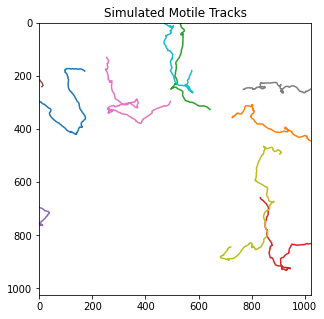

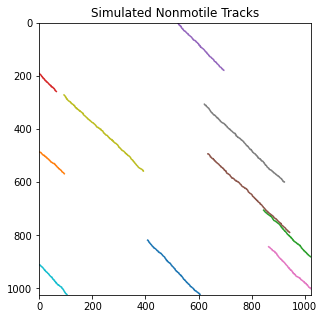

In [ ]:
# Plot 10 simulated motile tracks
plot_uids = random.choices(sim_motile_uids, k=10)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Motile Tracks')

# Plot 10 simulated nonmotile tracks
plot_uids = random.choices(sim_nonmotile_uids, k=10)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Nonmotile Tracks')

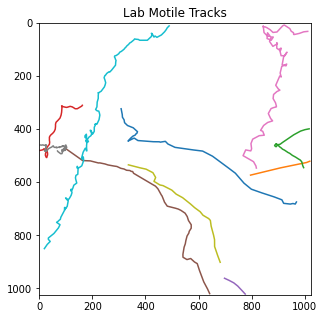

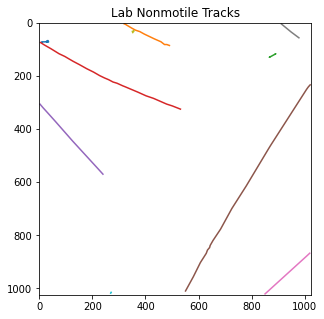

In [ ]:
# Plot 10 lab motile tracks
plot_uids = random.choices(lab_motile_uids, k=10)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Motile Tracks')

# Plot 10 lab nonmotile tracks
plot_uids = random.choices(lab_nonmotile_uids, k=10)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Nonmotile Tracks')

# Data preprocessing/feature engineering

In [ ]:
def mean_step_speed(coords):
    """Mean step speed of the entire track.

    The average per-step speed. Basically the average of distances between points adjacent in time.

    Returns
    -------
    float
        The average step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    # Return the average of the speeds
    return np.mean(speeds)


def stddev_step_speed(coords):
    """Standard deviation of the step speed of the entire track.

    The standard deviation of the per-step speed.

    Returns
    -------
    float
        The stddev of the step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    # Return the standard deviation of the speeds
    return np.std(speeds)


def track_length(coords):
    """Standard deviation of the step speed of the entire track.

    The standard deviation of the per-step speed.

    Returns
    -------
    float
        The length of the entire track.
    """

    lengths = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1,1:]
        # Current coordinate location
        curr = coords[i,1:]

        # Speed in pixels per frame
        step_length = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        lengths.append(step_length)

    # Return the sum of the lengths
    return np.sum(lengths)

def e2e_distance(coords):
    """End-to-end distance of the track.

    The distance from the start and the end of the given track.

    Returns
    -------
    float
        The end-to-end distance of the entire track.
    """

    # Start and end of the track
    start = coords[0, 1:]
    end = coords[-1, 1:]

    # Return the distance
    return np.linalg.norm(end-start)


def duration(coords):
    """Duration of the track.

    The time duration of the track.

    Returns
    -------
    int
        The end-to-end duration of the entire track.
    """

    # Start and end times of the track
    start_t = coords[0, 0]
    end_t = coords[-1, 0]

    # Return the difference
    return end_t - start_t

def max_step_speed(coords):
    """Maximum step speed of the entire track.

    The maximum per-step speed. Basically the maximum of distances between points adjacent in time.

    Returns
    -------
    float
        The maximum step speed.
    """

    speeds = []
    max_speed = 0

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

        #update the max speed
        max_speed = max(max_speed, curr_speed)

    # Return the average of the speeds
    return max_speed

def avg_accel(coords):
    """Average step acceleration of the entire track.

    The average per-step acceleration. Basically the average of the speeds between points adjacent in time.

    Returns
    -------
    float
        The average step acceleration.
    """

    speeds = []
    accels = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

        #accumulate the per-step acceleration
        if i >= 2:
          curr_accel = abs(curr_speed - speeds[i-2])
          accels.append(curr_accel)


    # Return the average of the speeds
    return np.mean(accels)

def max_accel(coords):
    """Maximum step acceleration of the entire track.

    The maximum per-step acceleration. Basically the maximum of the speeds between points adjacent in time.

    Returns
    -------
    float
        The maximum step acceleration.
    """

    speeds = []
    max_accel = 0

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

        #accumulate the per-step acceleration
        if i >= 2:
          curr_accel = abs(curr_speed - speeds[i-2])
          max_accel = max(curr_accel, max_accel)

    # Return the maximum of the accelerations
    return max_accel

def min_step_speed(coords):
    """Minimum step speed of the entire track.

    The minimum per-step speed. Basically the minimum of distances between points adjacent in time.

    Returns
    -------
    float
        The minimum step speed.
    """

    speeds = []
    min_speed = 1000

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]

        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)

        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

        #update the max speed
        min_speed = min(min_speed, curr_speed)

    # Return the average of the speeds
    return min_speed

def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    # return ang + 360 if ang < 0 else ang
    return abs(ang)

def avg_angle_change(coords):
    """ Mean change in angle over the entire track

    The change in angle between consecutive steps.

    Returns
    -------
    float
        The mean change in angle.
    """
    angles = []
    angle_change = []

    for i in range(2, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        # point 2 time before the current point
        prev_prev = coords[i-2, 1:]

        a = np.array(prev)
        b = np.array(curr)
        c = np.array(prev_prev)

        angles.append(getAngle(a, b, c))

        if len(angles) >= 2:
          angle_change.append(abs(angles[len(angles)-1] - angles[len(angles)-2]))

    if len(angle_change) == 0:
      return 0.0
    else:
      return np.mean(angle_change)

In [ ]:
#################################################
# Creating training set file with added features
#################################################

FEATURE_LIST = [max_step_speed, min_step_speed, avg_angle_change, avg_accel, max_accel, mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration]
TYPE = "train"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TRAIN_OUTPUT_FILENAME = f"/content/{TYPE}_features_{TIMESTAMP}.csv"


# Generate the feature csv
header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track_uids = track_data.keys()
for uid in track_uids:
    curr_row = {
        'uid': uid,
        'label': track_data[uid]['label']
    }

    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(track_data[uid]['txy']))

    features.append(curr_row)

with open(TRAIN_OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", TRAIN_OUTPUT_FILENAME)

Written to: /content/train_features_20230215_095656.csv


In [ ]:
df_processed = pd.read_csv(TRAIN_OUTPUT_FILENAME)
df_processed = df_processed.dropna()
df_processed = df_processed.drop(columns = ['max_step_speed', 'min_step_speed', 'duration', 'max_accel']) # remove non-important features
display(df_processed)

,uid,label,avg_angle_change,avg_accel,mean_step_speed,stddev_step_speed,track_length,e2e_distance
0,lab_0_0,0,5.387267,0.013493,0.173088,0.100141,51.926349,40.408772
1,lab_0_1,0,7.700989,0.011310,0.165048,0.086194,49.514298,32.957322
2,lab_0_2,0,8.616906,0.013796,0.167388,0.099177,50.216438,31.649486
3,lab_0_3,0,5.868148,0.013037,0.215927,0.109797,64.778077,42.524948
4,lab_0_4,0,7.786853,0.007031,0.097786,0.096984,29.335788,1.616936
...,...,...,...,...,...,...,...,...
16075,sim_419_59,0,98.540158,0.657167,1.531170,0.546807,176.084514,159.831161
16076,sim_419_60,0,105.939028,0.592266,1.539173,0.526780,357.088240,328.124976
16077,sim_419_61,0,105.765182,0.670106,1.532309,0.563054,306.461775,275.072718
16078,sim_419_62,0,83.283058,0.695790,1.446036,0.573567,144.603611,133.206606


In [ ]:
# Set the target file here
track_data = pd.read_json("https://raw.githubusercontent.com/anika24/CS155-Kaggle-MiniProject1/main/data/test.json")

# How many tracks are there?
print(f"n_tracks = {len(track_data.keys())}")

# What do the track Unique IDs (UIDs) look like?
track_uids = list(track_data.keys())
print(f"5 Example Track IDs = {track_uids[:5]}")

# What fields are avaiable for each track?
example_uid = track_uids[0]
print(f"Per-track keys = {track_data[example_uid].keys()}")

# What do the (t, x, y) track coordinates look like?
example_coords = track_data[track_uids[0]]['txy']
example_coords = np.array(example_coords)
np.set_printoptions(threshold=10)
print(f"Coordinate array = \n{example_coords}")

# What does the label look like?
example_label = track_data[track_uids[0]]['label']
print(f"Label = {example_label}")

n_tracks = 477
5 Example Track IDs = ['lab_19_0', 'lab_19_1', 'lab_19_2', 'lab_19_3', 'lab_19_4']
Per-track keys = Index(['txy', 'label'], dtype='object')
Coordinate array = 
[[  1. 802. 926.]
 [  2. 802. 926.]
 [  3. 802. 926.]
 ...
 [284. 805. 917.]
 [285. 805. 917.]
 [286. 805. 917.]]
Label = None


In [ ]:
#################################################
# Creating testing set file with added features
#################################################

FEATURE_LIST = [max_step_speed, min_step_speed, avg_angle_change, avg_accel, max_accel, mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration]
TYPE = "test"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TEST_OUTPUT_FILENAME = f"/content/{TYPE}_features_{TIMESTAMP}.csv"

header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track_uids = track_data.keys()
for uid in track_uids:
    curr_row = {
        'uid': uid,
        'label': track_data[uid]['label']
    }

    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(track_data[uid]['txy']))

    features.append(curr_row)

with open(TEST_OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", TEST_OUTPUT_FILENAME)

Written to: /content/test_features_20230215_100045.csv


In [ ]:
df_test_processed = pd.read_csv(TEST_OUTPUT_FILENAME)
df_test_processed = df_test_processed.drop(columns=['uid', 'label', 'max_step_speed', 'min_step_speed', 'duration', 'max_accel'])

display(df_test_processed)

,avg_angle_change,avg_accel,mean_step_speed,stddev_step_speed,track_length,e2e_distance
0,1.004027,0.021859,0.043518,0.318304,9.486833,9.486833
1,21.703655,0.520665,3.171025,1.509846,951.307598,104.139330
2,7.942671,5.471797,14.522454,4.294093,638.987982,601.146405
3,15.093728,1.471075,9.820072,3.126031,834.706124,766.600939
4,10.028803,0.558893,4.830739,0.937430,43.476651,37.854986
...,...,...,...,...,...,...
472,7.202292,1.597023,6.629493,2.251868,1312.639654,1198.296824
473,7.061568,1.156111,3.228414,5.807107,422.922179,344.420052
474,2.340253,0.150589,2.632726,0.815417,242.210827,150.622786
475,0.322149,0.042936,4.090725,0.218803,331.348692,331.148679


# Finding optimal hyperparameters for XGBoost Model

#### Optimizing various hyperparameter values with a mix of lab and simulated data as the training set



In [ ]:
# Use a proportion of lab and simulated data in the training and test sets
lab = df[df['uid'].str.startswith('lab')]  # 368 rows
sim = df[df['uid'].str.startswith('sim')]  # 15645 rows
sim = sim.drop('uid', axis = 1)
lab = lab.drop('uid', axis = 1)

train_lab = lab.sample(frac = 0.7)
train_sim = sim.sample(frac = 0.5)

train = pd.concat([train_lab, train_sim])
test = df.drop(train.index)
test = test.drop('uid', axis = 1)

X_train = train.drop('label', axis = 1)
X_test = test.drop('label', axis = 1)
y_train = train['label']
y_test = test['label']

In [ ]:
def classification_err(y, real_y):
    """
    This function returns the classification error between two equally-sized vectors of
    labels; this is the fraction of samples for which the labels differ.

    Inputs:
        y: (N, ) shaped array of predicted labels
        real_y: (N, ) shaped array of true labels
    Output:
        Scalar classification error
    """
    misclassified = np.sum(y != real_y)
    return 1.0 * misclassified / np.size(y);

def eval_tree_based_model_min_child_weight(clf, min_child_weights, X_train, y_train, X_test, y_test):
    train_err = np.empty(np.size(min_child_weights))
    test_err = np.empty(np.size(min_child_weights))
    idx = 0
    for min_child in min_child_weights:
      clf.set_params(min_samples_weight = min_child)
      clf.fit(X_train, y_train)
      train_err[idx] = classification_err(clf.predict(X_train), y_train)
      test_err[idx] = classification_err(clf.predict(X_test), y_test)
      idx += 1
    return train_err, test_err

def eval_tree_based_model_max_depth(clf, max_depth, X_train, y_train, X_test, y_test):
    train_err = np.empty(np.size(max_depth))
    test_err = np.empty(np.size(max_depth))
    idx = 0
    for depth in max_depth:
      clf.set_params(max_depth = depth)
      clf.fit(X_train, y_train)
      train_err[idx] = classification_err(clf.predict(X_train), y_train)
      test_err[idx] = classification_err(clf.predict(X_test), y_test)
      idx += 1
    return train_err, test_err

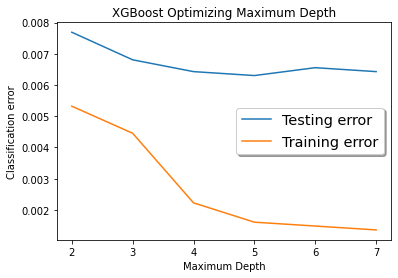

Test error minimized at max_depth = 5


In [ ]:
np.random.seed(1)

clf = XGBClassifier()

max_depth = np.arange(2, 8)

train_err, test_err = eval_tree_based_model_max_depth(clf, max_depth, X_train,
                                                        y_train, X_test, y_test)

plt.figure()
plt.plot(max_depth, test_err, label='Testing error')
plt.plot(max_depth, train_err, label='Training error')
plt.xlabel('Maximum Depth')
plt.ylabel('Classification error')
plt.title('XGBoost Optimizing Maximum Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at max_depth = %i' % max_depth[np.argmin(test_err)])

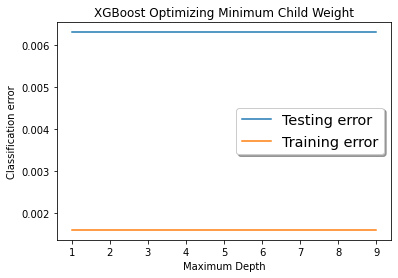

Test error minimized at minimum_child_weight = 1


In [ ]:
np.random.seed(1)

clf = XGBClassifier(max_depth = 5)

min_child_weights = np.arange(1, 10)

train_err, test_err = eval_tree_based_model_min_child_weight(clf, min_child_weights, X_train,
                                                        y_train, X_test, y_test)

plt.figure()
plt.plot(min_child_weights, test_err, label='Testing error')
plt.plot(min_child_weights, train_err, label='Training error')
plt.xlabel('Maximum Depth')
plt.ylabel('Classification error')
plt.title('XGBoost Optimizing Minimum Child Weight')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at minimum_child_weight = %i' % min_child_weights[np.argmin(test_err)])

#### Trying grid search to find the best hyperparameters

In [ ]:
parameters = {
    'max_depth': range (3, 7, 1),
    'min_child_weight': [1, 2, 3, 4],
    'n_estimators': [100, 200, 300]
}

In [ ]:
xg = XGBClassifier()
grid_search = GridSearchCV(estimator = xg, param_grid = parameters, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300})


In [ ]:
# We can try some of the above paramaters on the test data: take max_depth = 5, n_estimators 300, and min_child_weight 1
clf = XGBClassifier(max_depth = 5, n_estimators = 300, min_child_weight = 1)
eval_s = [(X_train, y_train),(X_test, y_test)]
clf.fit(X_train, y_train, eval_set=eval_s)

[0]	validation_0-error:0.005198	validation_1-error:0.009076
[1]	validation_0-error:0.004332	validation_1-error:0.007689
[2]	validation_0-error:0.004455	validation_1-error:0.007689
[3]	validation_0-error:0.004579	validation_1-error:0.007689
[4]	validation_0-error:0.004827	validation_1-error:0.007689
[5]	validation_0-error:0.004332	validation_1-error:0.006933
[6]	validation_0-error:0.004827	validation_1-error:0.006933
[7]	validation_0-error:0.004084	validation_1-error:0.006681
[8]	validation_0-error:0.00396	validation_1-error:0.006933
[9]	validation_0-error:0.004084	validation_1-error:0.006933
[10]	validation_0-error:0.00396	validation_1-error:0.006681
[11]	validation_0-error:0.00396	validation_1-error:0.006681
[12]	validation_0-error:0.00396	validation_1-error:0.006681
[13]	validation_0-error:0.00396	validation_1-error:0.006681
[14]	validation_0-error:0.00396	validation_1-error:0.006681
[15]	validation_0-error:0.00396	validation_1-error:0.006681
[16]	validation_0-error:0.00396	validatio

XGBClassifier(max_depth=5, n_estimators=300)

In [ ]:
predicted = clf.predict(X_test)
score = fbeta_score(y_test, predicted, beta = 2)
print("Test F2 score: " + str(score))

Test F2 score: 0.9944261464403346


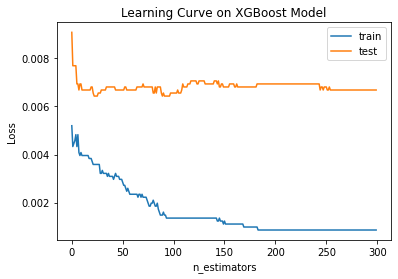

In [ ]:
results = clf.evals_result()
plt.plot(results['validation_0']['error'], label='train')
plt.plot(results['validation_1']['error'], label='test')
plt.title('Learning Curve on XGBoost Model')
plt.ylabel('Loss')
plt.xlabel('n_estimators')
plt.legend()

### Training the model above on sim data, testing on lab data to check generalization


In [ ]:
X_train = df_processed[df_processed['uid'].str.startswith('sim')]
X_test =  df_processed[df_processed['uid'].str.startswith('lab')]
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = X_train['label']
y_test = X_test['label']
X_train = X_train.drop(columns = ['uid', 'label'])
X_test = X_test.drop(columns = ['uid', 'label'])

In [ ]:
clf = XGBClassifier(max_depth = 5, n_estimators = 300, min_child_weight = 1)
clf.fit(X_train, y_train)

XGBClassifier(max_depth=5, n_estimators=300)

In [ ]:
predicted = clf.predict(X_test)
print("F2 score: " + str(fbeta_score(y_test, predicted, beta = 2)))

F2 score: 0.7272727272727273


# Final Model

#### Our best model used XGBoost with max_depth 5, n_estimators 300, and min_child_weight 1

In [ ]:
# Training on all of the data gave the best results, because we want to include all lab examples and simulated examples
X_train = df_processed
y_train = df_processed['label']
X_train = X_train.drop(columns = ['uid', 'label'])

In [ ]:
clf = XGBClassifier(max_depth = 5, n_estimators = 300, min_child_weight = 1)
clf.fit(X_train, y_train)

XGBClassifier(max_depth=5, n_estimators=300)

In [ ]:
predicted_test_target = clf.predict(df_test_processed)
print(predicted_test_target)
test_uids_vals = test_uids.values
print(test_uids_vals)

[0 1 1 ... 1 0 1]
['lab_19_0' 'lab_19_1' 'lab_19_2' ... 'lab_42_11' 'lab_42_12' 'lab_42_13']


In [ ]:
# Create submission file
with open('/content/test_submission.csv', 'w', newline='') as f:
  writer = csv.writer(f)
  header = ['UID', 'label']
  writer.writerow(header)
  for i in range(len(predicted_test_target)):
      row = [test_uids_vals[i], predicted_test_target[i]]
      writer.writerow(row)

In [ ]:
df_results = pd.read_csv("/content/test_submission.csv")
df_results

,UID,label
0,lab_19_0,0
1,lab_19_1,1
2,lab_19_2,1
3,lab_19_3,1
4,lab_19_4,1
...,...,...
472,lab_42_9,1
473,lab_42_10,1
474,lab_42_11,1
475,lab_42_12,0


# Visualizations

### Feature importance

<BarContainer object of 6 artists>

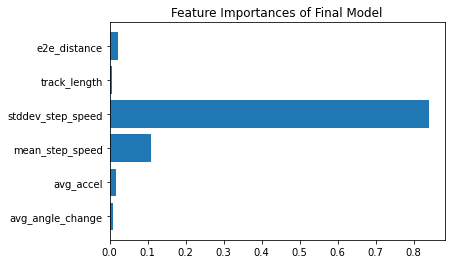

In [ ]:
df_processed = df_processed.drop(columns = ['label', 'uid'])
features = df_processed.columns.values
plt.title("Feature Importances of Final Model")
plt.barh(features, clf.feature_importances_)

### Visualizing Final Decision Tree

In [ ]:
xgboost.plot_tree(clf)
fig = plt.gcf()
fig.set_size_inches(450, 350)
plt.savefig("XGBoost Tree")
plt.show()